# **Taller Clasificación de Texto**

### Asignatura PLN
#### Universidad Nacional de Colombia
---


# Taller clasificación de textos - Análisis de sentimientos

El objetivo de este taller es construir clasificadores para el análisis de sentimientos. Se deberán utilizar diferentes representaciones de los documentos y diferentes modelos de aprendizaje maquinal.

Se utilizará el dataset para análisis de sentimientos de [Kaggle](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech), que busca identificar contenido odioso en tweets.

Este taller, contiene algún código para actividades, pero la mayoría las deben escribir ustedes.

In [1]:
# Importar librerías a usar
import pandas as pd
import numpy as np
import nltk, re, string, spacy, os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import seaborn as sns
np.random.seed(0)

from nltk.corpus import stopwords
from nltk import word_tokenize

In [2]:
# Armar el conjunto de datos
# corpus (datos) y labels (etiquetas)
tweet_df = pd.read_csv("../Files/hate/train.csv", index_col='id')
tweet_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


## 1. Preprocesamiento


-  Crear una función para preprocesar el corpus, esta función debe dejar todas las palabras en minúscula, eliminar caracteres especiales, separar signos de puntuación y eliminar stopwords.
El conjunto de datos se encuentra en las variables **corpus** y **labels**.


In [3]:
reg = re.compile(r'[A-Za-z\d\.,\'\s-]+')
def preprocessing(doc):
    document = doc.lower()
    document = ' '.join(reg.findall(document))
    tokens = word_tokenize(document)
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    return tokens

norm_corpus=tweet_df.tweet.apply(preprocessing)
norm_corpus

id
1        [user, father, dysfunctional, selfish, drags, ...
2        [user, user, thanks, lyft, credit, ca, n't, us...
3                                        [bihday, majesty]
4                      [model, love, u, take, u, time, ur]
5                        [factsguide, society, motivation]
                               ...                        
31958                              [ate, user, isz, youuu]
31959    [see, nina, turner, airwaves, trying, wrap, ma...
31960    [listening, sad, songs, monday, morning, otw, ...
31961    [user, sikh, temple, vandalised, calgary, ,, w...
31962                                [thank, user, follow]
Name: tweet, Length: 31962, dtype: object

In [4]:
corpus_df = pd.DataFrame( columns=['tokens'])
corpus_df['tokens'] = norm_corpus
corpus_df['text'] = corpus_df['tokens'].apply(' '.join)
corpus_df[['text']]

,text
id,
1,user father dysfunctional selfish drags kids d...
2,user user thanks lyft credit ca n't use cause ...
3,bihday majesty
4,model love u take u time ur
5,factsguide society motivation
...,...
31958,ate user isz youuu
31959,see nina turner airwaves trying wrap mantle ge...
31960,listening sad songs monday morning otw work sad


## 2. Análisis exploratorio de los datos

* Encuentre la proporción de documentos de odio y la proporción de documentos normales.
* Construya una nube de palabras para cada categoría.
* Divida el dataset en un conjunto de entrenamiento (60%) y prueba (40%)
* Discuta los resultados.

In [5]:
# Proporción de los datos
path = "../Files/EmoLex"
vocab={}
words = set()
for lexicon in os.listdir(path):
    # Se abre cada .txt, se extraen todas las palabras y se eliminan saltos de línea.
    with open(f"{path}/{lexicon}","r") as f:
        feeling = lexicon.split(".")[0]
        vocab[feeling] = [i.strip() for i in f.readlines()]
        words.update(vocab[feeling])

lexicon_df = pd.DataFrame(0, index=words, columns=vocab.keys() )
for feeling, words in vocab.items():
    lexicon_df.at[words, [feeling]] = 1
lexicon_df.sum()

anticipation     839
joy              689
positive        2312
disgust         1058
surprise         534
fear            1476
negative        3324
anger           1247
sadness         1191
trust           1231
dtype: int64

## Unify hate lexicons

In [6]:
hate_feeling = {'disgust', 'fear', 'negative', 'anger', 'sadness'}
hate_lex_df = lexicon_df[hate_feeling]
hate_lex_df = hate_lex_df[ hate_lex_df.sum(axis=1) > 0 ]
hate_lex_df

,negative,fear,disgust,anger,sadness
docked,1,0,0,0,0
juvenile,1,0,0,0,0
damn,1,0,1,1,0
acrobat,0,1,0,0,0
dilapidated,1,0,1,0,1
...,...,...,...,...,...
perishable,1,0,0,0,0
compulsory,1,0,0,0,0
eviction,1,1,1,1,1
strike,1,0,0,1,0


## Unify normal lexicons

In [7]:
normal_feeling = {'anticipation', 'joy', 'positive', 'surprise', 'trust'}
normal_lex_df = lexicon_df[normal_feeling]
normal_lex_df = normal_lex_df[ normal_lex_df.sum(axis=1) > 0 ]
normal_lex_df

,joy,positive,surprise,trust,anticipation
acrobat,1,1,0,1,0
machine,0,0,0,1,0
remarkable,1,1,1,1,0
finesse,0,1,0,0,0
legitimacy,0,0,0,1,0
...,...,...,...,...,...
spirit,0,1,0,0,0
correctness,0,0,0,1,0
cohesion,0,0,0,1,0
clothe,0,1,0,0,0


In [8]:
def count_sentiments(tokens):
    hate_tokens = [t for t in tokens if t in hate_lex_df.index]
    normal_tokens = [t for t in tokens if t in normal_lex_df.index]
    hate_tokens, normal_tokens = len(hate_tokens), len(normal_tokens)
    
    return pd.Series([hate_tokens, normal_tokens], index=['hate', 'normal'])
        
sentiment_df = corpus_df.tokens.apply(count_sentiments)
sentiment_df = pd.concat([corpus_df, sentiment_df], axis=1)
sentiment_df

,tokens,text,hate,normal
id,,,,
1,"[user, father, dysfunctional, selfish, drags, ...",user father dysfunctional selfish drags kids d...,1,1
2,"[user, user, thanks, lyft, credit, ca, n't, us...",user user thanks lyft credit ca n't use cause ...,0,2
3,"[bihday, majesty]",bihday majesty,0,1
4,"[model, love, u, take, u, time, ur]",model love u take u time ur,0,3
5,"[factsguide, society, motivation]",factsguide society motivation,0,0
...,...,...,...,...
31958,"[ate, user, isz, youuu]",ate user isz youuu,0,0
31959,"[see, nina, turner, airwaves, trying, wrap, ma...",see nina turner airwaves trying wrap mantle ge...,1,2
31960,"[listening, sad, songs, monday, morning, otw, ...",listening sad songs monday morning otw work sad,0,0


In [9]:
sentiment_df['label'] = 0
sentiment_df.label.at[ 
  sentiment_df.hate >= sentiment_df.normal
  & sentiment_df[['normal', 'hate']].sum(axis=1)
] = 1
sentiment_df[['text', 'label']]

,text,label
id,,
1,user father dysfunctional selfish drags kids d...,1
2,user user thanks lyft credit ca n't use cause ...,0
3,bihday majesty,0
4,model love u take u time ur,0
5,factsguide society motivation,1
...,...,...
31958,ate user isz youuu,1
31959,see nina turner airwaves trying wrap mantle ge...,0
31960,listening sad songs monday morning otw work sad,1


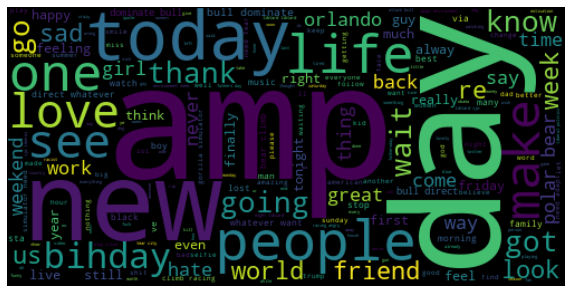

In [10]:
# Nube de palabras Negativas
from wordcloud import WordCloud

text = '\n'.join(corpus_df[sentiment_df.label == 1].text)
text = text.replace('user', '')
text = text.replace('ca', 'can')
text = text.replace("n't", 'not')

wordcloud = WordCloud(width=500, height=250).generate(text)

# Display the generated image:
plt.figure(1, figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

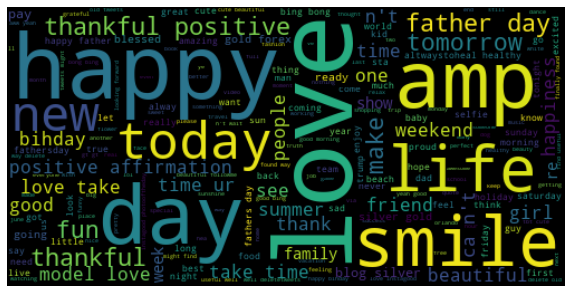

In [11]:
# Nube de palabras Negativas
text = '\n'.join(corpus_df[sentiment_df.label == 0].text)
text = text.replace('user', '')
# text = text.replace('ca', 'can')
# text = text.replace("n't", 'not')

wordcloud = WordCloud(width=500, height=250).generate(text)

# Display the generated image:
plt.figure(1, figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
# Trainign and testing sets

lenght = len(corpus_df)
train_len = int(lenght * 0.6)
train_df = corpus_df.loc[:train_len]
test_df = corpus_df.loc[train_len:]

print(f'''
train dataset: {len(train_df)}
test dataset: {len(test_df)}
''')


train dataset: 19177
test dataset: 12786



In [13]:
# Validación cruzada
test = sentiment_df.loc[test_df.index]
test['real_label'] = tweet_df.loc[test_df.index].label

total_perdictions = len(test['real_label'])
correct_predictions = len(test[test.real_label == test.label])

acuracy = correct_predictions / total_perdictions

print(f'{acuracy * 100:.2f}% de las predicciones fueron correctas.')

51.38% de las predicciones fueron correctas.


## 3. Representación de los textos



1.    
     * Construya una bolsa de palabras para representar los textos.
      
      
2.   * Construya una representación tfidf
3. 
   * Entrene un modelo Word2Vec con el conjunto de entrenamiento.
   * Construya una función que obtenga la representación de un documento como el promedio de sus términos.
   * Construya una función que obtenga la representación de un documento como el promedio de sus 5 palabras más largas.
    

***Nota: si algún documento resulta vacío luego del preprocesamiento, asignele un vector de ceros como representación. Si algún documento tiene menos de 5 palabras, promedie sólo esas palabras.***

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [15]:
# Bolsa de palabras
cv = CountVectorizer()
cv_matrix = cv.fit_transform(train_df.text)

print(cv_matrix.shape)
print(cv_matrix.toarray())

(19177, 28324)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
# Representación TFIDF

tt = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, sublinear_tf=True)
tt_matrix = tt.fit_transform(train_df.text)

print(tt_matrix.shape)
print(tt_matrix.toarray())

(19177, 28324)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
# Word2Vec
# from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(train_df.tokens, size=50, window=5, min_count=1, workers=4)
model

In [18]:
def to_vect(t):
    if t in model:
        return model[t]
    return np.zeros(model.vector_size, dtype=np.float32)
to_vect("@")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [67]:
# Representación word2vec 1
def w2v_repr1(doc_tokenized):
    if len(doc_tokenized) == 0:
        return np.zeros(model.vector_size, dtype=np.float32)
    
    vectors = np.array([to_vect(t) for t in doc_tokenized])
    return pd.Series(vectors.mean(axis=0))

w2v1_train = train_df.tokens.apply(w2v_repr1).to_numpy()
w2v1_train[0]

array([ 0.7146889 , -0.16128448, -0.04797563,  0.61770874, -0.6941366 ,
       -0.10351571, -0.54699296, -0.58004516,  0.5687202 ,  0.85606164,
        0.0372273 , -0.1812349 , -0.5247388 ,  0.14036047, -0.5583594 ,
       -1.0111061 ,  0.31832373,  0.32567006, -0.53832567,  0.14021719,
       -1.3161364 ,  0.6811725 ,  0.03050163, -0.34206071, -1.1116428 ,
       -0.6240619 , -0.04277918, -0.69913584,  0.10344103,  0.6372382 ,
        0.06064753,  0.20222127,  1.182694  ,  0.40784788, -0.5620204 ,
        1.1103711 , -0.29478824, -0.41040066,  0.07283393, -0.4218797 ,
        0.35679707,  0.58568215,  0.46130213, -0.22961235, -0.9048458 ,
       -0.11646552,  0.83176136, -0.8106213 , -0.5594186 ,  0.2894274 ],
      dtype=float32)

In [68]:
# Representación word2vec 2
def w2v_repr2(doc_tokenized, n=5):
    tokens = doc_tokenized.copy()
    tokens.sort(key=len, reverse=True)
    return w2v_repr1(tokens[:n])

w2v2_train = train_df.tokens.apply(w2v_repr2).to_numpy()
w2v2_train[0]

array([ 0.37590158, -0.11014698,  0.0199534 ,  0.15549535, -0.2858899 ,
        0.14735283, -0.14478181, -0.13991742,  0.13124637,  0.18348768,
        0.0297129 , -0.19316009, -0.36998457,  0.20319045, -0.13022241,
       -0.40210143,  0.26454335,  0.11829627, -0.17149663, -0.01379449,
       -0.57965505,  0.18408747, -0.09024425, -0.1838187 , -0.52944624,
       -0.21585259, -0.22889963, -0.29700866,  0.16609511,  0.22079735,
        0.01575929,  0.09669857,  0.3325345 ,  0.25722384, -0.27204597,
        0.3898031 , -0.14605173, -0.1737184 , -0.051758  , -0.10088953,
        0.24778593,  0.26727337,  0.09502949, -0.1052783 , -0.3338988 ,
       -0.07520319,  0.27381077, -0.1774724 , -0.20174845,  0.1252936 ],
      dtype=float32)

## 4. Clasificación

Entrene un modelo Naive bayes para cada una de las representaciones usando el corpus de datos.

***Nota: tenga cuidado con la selección de la función de verosimilitud: multinomial o Gaussian***

In [21]:
train_Y = tweet_df.loc[train_df.index].label
test_Y = tweet_df.loc[test_df.index].label

In [81]:
# Modelo para la bolsa de palabras
from sklearn.naive_bayes import MultinomialNB

nb_bow = MultinomialNB()
nb_bow.fit(cv_matrix, train_Y)

X_test = cv.transform(test_df.text)

print(f'{nb_bow.score(X_test, test_Y)*100:.2f}% de acuracy parra Naive Bayes con Bag of Words')

95.49% de acuracy parra Naive Bayes con Bag of Words


In [82]:
# Modelo para tfidf
nb_tt = MultinomialNB()
nb_tt.fit(tt_matrix, train_Y)

X_test = cv.transform(test_df.text)

print(f'{nb_tt.score(X_test, test_Y)*100:.2f}% de acuracy parra Naive Bayes')

94.35% de acuracy parra Naive Bayes


In [101]:
# Modelo para la primer representación word2vec
from sklearn.naive_bayes import GaussianNB

gnb_v1 = GaussianNB()
gnb_v1.fit(w2v1_train, train_Y)

X_test = test_df.tokens.apply(w2v_repr1).to_numpy()

print(f'{gnb_v1.score(X_test, test_Y) * 100:.2f}% de acuracy para Naive Bayes con Word2Vec representación 1')

44.81% de acuracy para Naive Bayes con Word2Vec representación 1


In [102]:
# Modelo para la segunda representación word2vec
gnb_v2 = GaussianNB()
gnb_v2.fit(w2v2_train, train_Y)

X_test = test_df.tokens.apply(w2v_repr2).to_numpy()

print(f'{gnb_v2.score(X_test, test_Y) * 100:.2f}% de acuracy para Naive Bayes con Word2Vec representación 2')

44.35% de acuracy para Naive Bayes con Word2Vec representación 2


## 5. Validación

* Evalúe el desempeño de los tres modelos por medio de métricas como accuracy, precision, f1 y recall.
* Visualice la matríz de confusión.
* Discuta los resultados, ¿hay diferencia entre un promedio total y un promedio con las 10 palabras más largas?.

In [93]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

In [98]:
# Evaluación del modelo de bolsa de palabras
X_test = cv.transform(test_df.text)

prerdict_Y = nb_bow.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
pd.DataFrame(confusion_matrix(test_Y, prerdict_Y))


Acuracy:	0.9548725168152667
Percision:	0.8510204081632653
F1:		0.591070163004961
Recall:		0.4527687296416938

Matriz de confucion:



,0,1
0,11792,73
1,504,417


In [99]:
# Evaluación del modelo de tfifd
X_test = test_df.tokens.apply(w2v_repr1).to_numpy()

prerdict_Y = test_df.tokens.apply(w2v_repr1).to_numpy()

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
pd.DataFrame(confusion_matrix(test_Y, prerdict_Y))


Acuracy:	0.9375097763178476
Percision:	1.0
F1:		0.2339405560882071
Recall:		0.13246471226927253

Matriz de confucion:



,0,1
0,11865,0
1,799,122


In [104]:
# Evaluación del primer modelo word2vec
X_test = test_df.tokens.apply(w2v_repr1).to_numpy()

prerdict_Y = gnb_v1.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
pd.DataFrame(confusion_matrix(test_Y, prerdict_Y))


Acuracy:	0.4480681995933052
Percision:	0.09503695881731784
F1:		0.169471578204072
Recall:		0.7817589576547231

Matriz de confucion:



,0,1
0,5009,6856
1,201,720


In [105]:
# Evaluación del segundo modelo word2vec
X_test = test_df.tokens.apply(w2v_repr2).to_numpy()

prerdict_Y = gnb_v2.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
pd.DataFrame(confusion_matrix(test_Y, prerdict_Y))


Acuracy:	0.4435319881119975
Percision:	0.09705958886286756
F1:		0.17334727547345186
Recall:		0.8099891422366993

Matriz de confucion:



,0,1
0,4925,6940
1,175,746


# 6. Aplicación
Utilice el API de twitter para descargar 100 tweets de cada uno de los siguientes temas: "Donald Trump", "Feminism", "Soccer".
Utilice la función de preprocesamiento para limpiar estos tweets.
Seleccione el modelo con el mejor f1 score y utilicelo para predecir estos tweets.
¿Encontró contenido de odio?, discuta los resultados.


In [32]:
# Construcción del corpus

# Escriba su código aquí



In [33]:
# preprocesamiento

# Escriba su código aquí

In [34]:
# Representación de modelo con mejor f1

# Escriba su código aquí



In [35]:
# Ejemplo de contenido de odio

# Escriba su código aquí